In [1]:
import pandas as pd
import re , string,nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, classification_report
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from collections import Counter
import squarify
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#import dataset and remove unneccesary column
df=pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")
df.drop(columns = ['ID', 'Resume_html'], inplace = True)

In [3]:
#Missing values in training set
df.isnull().sum()

Resume_str    0
Category      0
dtype: int64

#### View those category column with plot

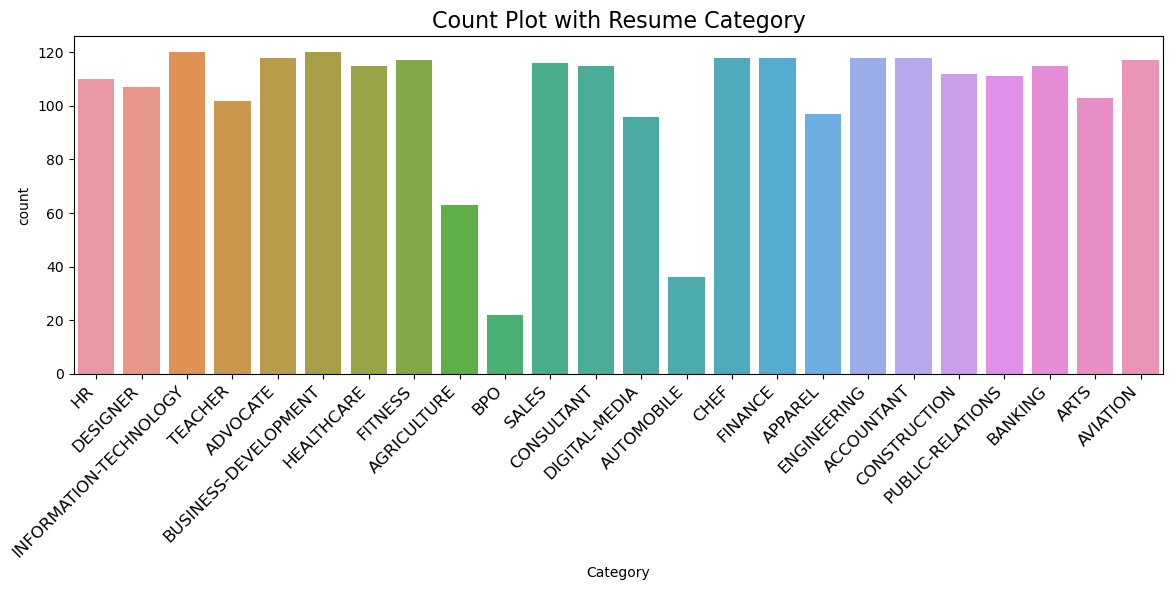

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='Category', data=df)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12) 
plt.title('Count Plot with Resume Category', fontsize=16)

plt.tight_layout()
plt.show()

#### Most Common words in Selected Text

In [4]:
def Common_words(df):
    df['temp_list'] = df.apply(lambda x:str(x).split())
    top = Counter([item for sublist in df['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp.style.background_gradient(cmap='Blues'), temp

In [5]:
temp1, temp2=Common_words(df['Resume_str'])
temp1

,Common_words,count
0,and,122399
1,to,53429
2,of,42633
3,the,35494
4,for,28105
5,in,27020
6,with,21462
7,",",18910
8,a,15613
9,State,15278


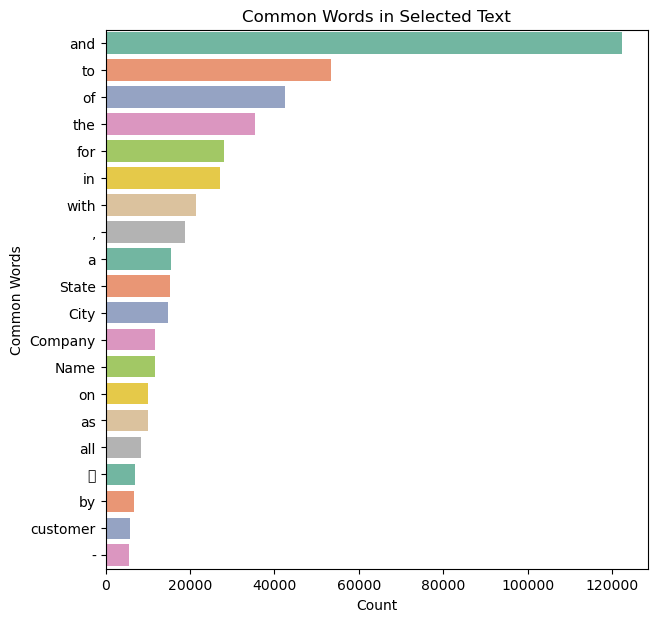

In [7]:
plt.figure(figsize=(7, 7))
sns.barplot(data=temp2, x="count", y="Common_words", palette='Set2')
plt.title('Common Words in Selected Text')
plt.xlabel('Count')
plt.ylabel('Common Words')
plt.show()

we can see hyphens(-) and other stopwords and punctuation from the plot so it unneccesarry, So  Lets remove that.

#### Clean the text data

In [9]:
def toclean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    clean_text = [word for word in clean_text.split() if word.lower() not in stopwords.words('english')]
    clean_text = ' '.join(clean_text)
    return clean_text

In [10]:
df['clean_text'] = df['Resume_str'].apply(lambda w: toclean_text(w))

In [11]:
## After preprocessing those words are
temp1, temp2=Common_words(df['clean_text'])
temp1

,Common_words,count
0,State,15328
1,City,14942
2,Company,11889
3,Name,11651
4,management,6918
5,－,6890
6,customer,5923
7,sales,5552
8,new,5463
9,Management,4996


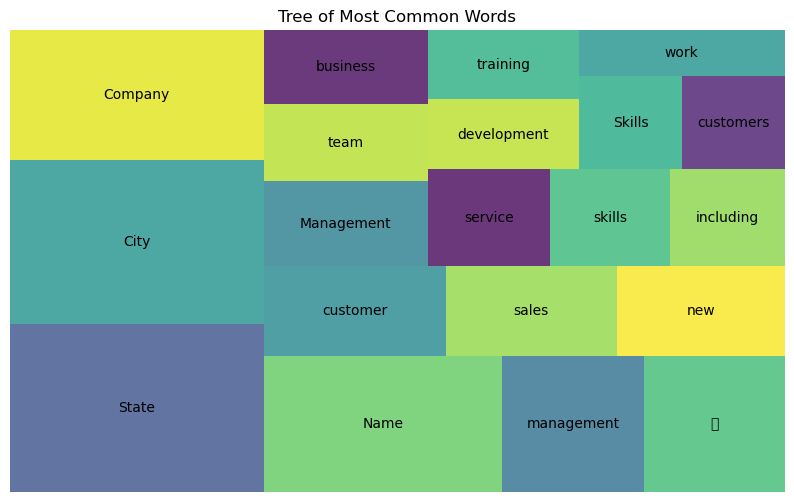

In [14]:
#Tree Map for most common word
plt.figure(figsize=(10, 6))
squarify.plot(sizes=temp2['count'], label=temp2['Common_words'], alpha=0.8)
plt.axis('off')
plt.title('Tree of Most Common Words')
plt.show()

#### Count most common words with Each Categories

In [26]:
most_common_words_by_label = {}
for label in df['Category'].unique():
    label_text = ' '.join(df[df['Category'] == label]['clean_text'])
    words = label_text.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)  
    most_common_words_by_label[label] = most_common_words

In [27]:
for label, words in most_common_words_by_label.items():
    print(f"Label: {label}")
    for word, count in words:
        print(f"{word}: {count}")
    print()
    

Label: HR
NUMBER: 2690
HR: 1043
employee: 621
State: 610
City: 567
management: 520
Company: 487
employees: 486
Name: 454
Human: 446

Label: DESIGNER
NUMBER: 2865
City: 725
State: 702
design: 631
Company: 547
Name: 539
Designer: 309
Design: 302
development: 190
new: 185

Label: INFORMATION-TECHNOLOGY
NUMBER: 4217
State: 621
City: 615
Information: 551
support: 542
Name: 515
Company: 514
systems: 475
management: 460
Management: 432

Label: TEACHER
NUMBER: 2387
students: 681
State: 673
City: 632
Company: 449
Name: 442
student: 372
Education: 347
learning: 318
Teacher: 305

Label: ADVOCATE
NUMBER: 3336
State: 875
City: 829
Company: 626
Name: 618
customer: 555
service: 378
skills: 326
management: 316
customers: 264

Label: BUSINESS-DEVELOPMENT
NUMBER: 3719
sales: 1037
State: 749
City: 710
business: 595
Company: 584
Name: 564
new: 558
Business: 458
customer: 433

Label: HEALTHCARE
NUMBER: 3218
State: 769
City: 740
Company: 568
Name: 558
care: 426
patient: 404
management: 372
patients: 325
cus

Look here, `Number`, `state`, `city` and `name` is common for all Label and I guess not important for classification. lets remove those from dataset

In [71]:
def remove_words(text, words_to_remove):
    for word in words_to_remove:
        text = text.replace(word, '')
    return text.strip()

In [73]:
words_to_remove = ['NUMBER', 'State', 'City', 'Name', 'Company']
df['finale_text'] = df['clean_text'].apply(lambda text: remove_words(text, words_to_remove))

In [40]:
## After preprocessing those words are
temp1, temp2=Common_words(df['finale_text'])
temp1

,Common_words,count
0,management,7011
1,customer,6156
2,sales,5645
3,new,5518
4,Management,5085
5,team,4728
6,business,4462
7,service,4427
8,skills,4188
9,including,4003


#### feature Extraction using TfidfVectorizer

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    sublinear_tf=True,
    stop_words='english',
    max_features=3000)
word_vectorizer.fit(df['finale_text'].values)
WordFeatures = word_vectorizer.transform(df['finale_text'].values)

In [86]:
#save feature extraction as pickle
with open("tfidf_models.pkl", "wb") as pkl_file:
    pickle.dump(word_vectorizer, pkl_file)

In [75]:
# divided training and validation dataset
X_train, X_test, y_train, y_test= train_test_split(WordFeatures,df['Category'],test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid= train_test_split(X_train,y_train, test_size=0.15, random_state=42)

#### Model LGBM

Apply several model like Catboost, XGBoost but get better result on LGBM so I pick that one for further execution. 

In [45]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 24,  # Number of classes in the target variable
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    #train and evaluation the LightGBM model
    model = lgb.LGBMClassifier(**params)
    eval_set = (X_valid, y_valid)
    model.fit(X_train, y_train, eval_set=eval_set)
    # Predict on the validation set and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    return accuracy

# optimize the objective function
study = optuna.create_study(direction="maximize")  # "maximize" for accuracy
study.optimize(objective, n_trials=40)

# best hyperparameters and accuracy
bestParams = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", bestParams)
print("Best Accuracy:", best_accuracy)

[I 2023-08-13 10:47:34,717] A new study created in memory with name: no-name-52fa8d7a-60c5-4f83-8fa4-97c827216166


[1]	valid_0's multi_logloss: 2.48513
[2]	valid_0's multi_logloss: 2.15827
[3]	valid_0's multi_logloss: 1.89979
[4]	valid_0's multi_logloss: 1.74133
[5]	valid_0's multi_logloss: 1.61283
[6]	valid_0's multi_logloss: 1.5232
[7]	valid_0's multi_logloss: 1.43974
[8]	valid_0's multi_logloss: 1.36425
[9]	valid_0's multi_logloss: 1.3007
[10]	valid_0's multi_logloss: 1.25251
[11]	valid_0's multi_logloss: 1.20838
[12]	valid_0's multi_logloss: 1.16482
[13]	valid_0's multi_logloss: 1.13226
[14]	valid_0's multi_logloss: 1.0994
[15]	valid_0's multi_logloss: 1.07117
[16]	valid_0's multi_logloss: 1.04259
[17]	valid_0's multi_logloss: 1.02429
[18]	valid_0's multi_logloss: 1.00972
[19]	valid_0's multi_logloss: 0.989138
[20]	valid_0's multi_logloss: 0.972697
[21]	valid_0's multi_logloss: 0.957442
[22]	valid_0's multi_logloss: 0.943645
[23]	valid_0's multi_logloss: 0.937223
[24]	valid_0's multi_logloss: 0.929055
[25]	valid_0's multi_logloss: 0.917594
[26]	valid_0's multi_logloss: 0.907276
[27]	valid_0's m

[I 2023-08-13 10:47:51,011] Trial 0 finished with value: 0.7565392354124748 and parameters: {'lambda_l1': 2.274679682949995e-05, 'lambda_l2': 0.00024117296037817353, 'num_leaves': 2, 'feature_fraction': 0.577388992029288, 'bagging_fraction': 0.837261286768329, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 0 with value: 0.7565392354124748.


[100]	valid_0's multi_logloss: 0.809966
[LightGBM] [Warning] lambda_l1 is set=0.02784152345800739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02784152345800739
[LightGBM] [Warning] bagging_fraction is set=0.6891496282026426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6891496282026426
[LightGBM] [Warning] lambda_l2 is set=0.016558530804214253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016558530804214253
[LightGBM] [Warning] feature_fraction is set=0.5015802747029287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5015802747029287
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's multi_logloss: 2.56126
[2]	valid_0's multi_logloss: 2.21088
[3]	valid_0's multi_logloss: 1.9654
[4]	valid_0's multi_logloss: 1.78548
[5]	valid_0's multi_logloss: 1.6585
[6]	valid_0's multi_logloss: 1.55146
[7]	valid_0's multi_logloss: 1.45418
[8]	valid_0's multi_l

[I 2023-08-13 10:48:17,435] Trial 1 finished with value: 0.7625754527162978 and parameters: {'lambda_l1': 0.02784152345800739, 'lambda_l2': 0.016558530804214253, 'num_leaves': 52, 'feature_fraction': 0.5015802747029287, 'bagging_fraction': 0.6891496282026426, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 1 with value: 0.7625754527162978.


[100]	valid_0's multi_logloss: 0.853182
[LightGBM] [Warning] lambda_l1 is set=3.0708736706278246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0708736706278246e-07
[LightGBM] [Warning] bagging_fraction is set=0.961147944152796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961147944152796
[LightGBM] [Warning] lambda_l2 is set=1.7834631020985294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7834631020985294
[LightGBM] [Warning] feature_fraction is set=0.9604881473815388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604881473815388
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's multi_logloss: 2.53089
[2]	valid_0's multi_logloss: 2.17887
[3]	valid_0's multi_logloss: 1.95716
[4]	valid_0's multi_logloss: 1.78688
[5]	valid_0's multi_logloss: 1.6592
[6]	valid_0's multi_logloss: 1.55948
[7]	valid_0's multi_logloss: 1.4723
[8]	valid_0's multi_l

[I 2023-08-13 10:48:41,003] Trial 2 finished with value: 0.738430583501006 and parameters: {'lambda_l1': 3.0708736706278246e-07, 'lambda_l2': 1.7834631020985294, 'num_leaves': 208, 'feature_fraction': 0.9604881473815388, 'bagging_fraction': 0.961147944152796, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 1 with value: 0.7625754527162978.


[100]	valid_0's multi_logloss: 0.956943
[LightGBM] [Warning] lambda_l1 is set=0.010190403197603013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010190403197603013
[LightGBM] [Warning] bagging_fraction is set=0.17281480181502717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17281480181502717
[LightGBM] [Warning] lambda_l2 is set=1.953251806304296e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.953251806304296e-05
[LightGBM] [Warning] feature_fraction is set=0.5315262675854094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5315262675854094
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[1]	valid_0's multi_logloss: 3.06045
[2]	valid_0's multi_logloss: 3.00701
[3]	valid_0's multi_logloss: 2.9194
[4]	valid_0's multi_logloss: 2.84639
[5]	valid_0's multi_logloss: 2.76353
[6]	valid_0's multi_logloss: 2.68505
[7]	valid_0's multi_logloss: 2.61858
[8]	valid_0's 

[I 2023-08-13 10:48:50,056] Trial 3 finished with value: 0.5915492957746479 and parameters: {'lambda_l1': 0.010190403197603013, 'lambda_l2': 1.953251806304296e-05, 'num_leaves': 66, 'feature_fraction': 0.5315262675854094, 'bagging_fraction': 0.17281480181502717, 'bagging_freq': 9, 'min_child_samples': 86}. Best is trial 1 with value: 0.7625754527162978.


[100]	valid_0's multi_logloss: 1.31686
[LightGBM] [Warning] lambda_l1 is set=0.0011032026573688214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011032026573688214
[LightGBM] [Warning] bagging_fraction is set=0.8277011307576982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8277011307576982
[LightGBM] [Warning] lambda_l2 is set=2.6580497354750747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6580497354750747
[LightGBM] [Warning] feature_fraction is set=0.9436711828282065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9436711828282065
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's multi_logloss: 2.56858
[2]	valid_0's multi_logloss: 2.21332
[3]	valid_0's multi_logloss: 1.97014
[4]	valid_0's multi_logloss: 1.78516
[5]	valid_0's multi_logloss: 1.64354
[6]	valid_0's multi_logloss: 1.52973
[7]	valid_0's multi_logloss: 1.43605
[8]	valid_0's mult

[I 2023-08-13 10:48:59,800] Trial 4 finished with value: 0.7525150905432596 and parameters: {'lambda_l1': 0.0011032026573688214, 'lambda_l2': 2.6580497354750747, 'num_leaves': 2, 'feature_fraction': 0.9436711828282065, 'bagging_fraction': 0.8277011307576982, 'bagging_freq': 10, 'min_child_samples': 39}. Best is trial 1 with value: 0.7625754527162978.


[99]	valid_0's multi_logloss: 0.772418
[100]	valid_0's multi_logloss: 0.774046
[LightGBM] [Warning] lambda_l1 is set=4.509094537531267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.509094537531267
[LightGBM] [Warning] bagging_fraction is set=0.900670689944963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.900670689944963
[LightGBM] [Warning] lambda_l2 is set=1.950683298386294e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.950683298386294e-06
[LightGBM] [Warning] feature_fraction is set=0.48165652036978757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48165652036978757
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[1]	valid_0's multi_logloss: 2.53163
[2]	valid_0's multi_logloss: 2.23971
[3]	valid_0's multi_logloss: 1.99941
[4]	valid_0's multi_logloss: 1.83292
[5]	valid_0's multi_logloss: 1.7024
[6]	valid_0's multi_logloss: 1.58614
[7]	valid_0's multi_

[I 2023-08-13 10:49:25,456] Trial 5 finished with value: 0.7605633802816901 and parameters: {'lambda_l1': 4.509094537531267, 'lambda_l2': 1.950683298386294e-06, 'num_leaves': 256, 'feature_fraction': 0.48165652036978757, 'bagging_fraction': 0.900670689944963, 'bagging_freq': 9, 'min_child_samples': 38}. Best is trial 1 with value: 0.7625754527162978.


[100]	valid_0's multi_logloss: 0.810469
[LightGBM] [Warning] lambda_l1 is set=9.420375924497764e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.420375924497764e-05
[LightGBM] [Warning] bagging_fraction is set=0.29958033248704363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29958033248704363
[LightGBM] [Warning] lambda_l2 is set=0.006611588501012618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006611588501012618
[LightGBM] [Warning] feature_fraction is set=0.6118425287377444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6118425287377444
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's multi_logloss: 2.54432
[2]	valid_0's multi_logloss: 2.18087
[3]	valid_0's multi_logloss: 1.94234
[4]	valid_0's multi_logloss: 1.77868
[5]	valid_0's multi_logloss: 1.66177
[6]	valid_0's multi_logloss: 1.549
[7]	valid_0's multi_logloss: 1.44868
[8]	valid_0's m

[I 2023-08-13 10:49:49,377] Trial 6 finished with value: 0.7344064386317908 and parameters: {'lambda_l1': 9.420375924497764e-05, 'lambda_l2': 0.006611588501012618, 'num_leaves': 24, 'feature_fraction': 0.6118425287377444, 'bagging_fraction': 0.29958033248704363, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 1 with value: 0.7625754527162978.


[LightGBM] [Warning] lambda_l1 is set=3.8146473845796365e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8146473845796365e-05
[LightGBM] [Warning] bagging_fraction is set=0.1388303320352201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1388303320352201
[LightGBM] [Warning] lambda_l2 is set=1.0538826166177992e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0538826166177992e-05
[LightGBM] [Warning] feature_fraction is set=0.5698145622330937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5698145622330937
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[1]	valid_0's multi_logloss: 2.98811
[2]	valid_0's multi_logloss: 2.85754
[3]	valid_0's multi_logloss: 2.72633
[4]	valid_0's multi_logloss: 2.60794
[5]	valid_0's multi_logloss: 2.46746
[6]	valid_0's multi_logloss: 2.36276
[7]	valid_0's multi_logloss: 2.27176
[8]	valid_0's multi_logloss: 2.17367
[9]	valid_0'

[I 2023-08-13 10:49:56,953] Trial 7 finished with value: 0.6921529175050302 and parameters: {'lambda_l1': 3.8146473845796365e-05, 'lambda_l2': 1.0538826166177992e-05, 'num_leaves': 2, 'feature_fraction': 0.5698145622330937, 'bagging_fraction': 0.1388303320352201, 'bagging_freq': 9, 'min_child_samples': 48}. Best is trial 1 with value: 0.7625754527162978.


[100]	valid_0's multi_logloss: 1.127
[LightGBM] [Warning] lambda_l1 is set=0.03761275458229568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03761275458229568
[LightGBM] [Warning] bagging_fraction is set=0.4912085462715037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4912085462715037
[LightGBM] [Warning] lambda_l2 is set=2.1231659553481637e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1231659553481637e-06
[LightGBM] [Warning] feature_fraction is set=0.8478498080851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8478498080851107
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[1]	valid_0's multi_logloss: 2.04872
[2]	valid_0's multi_logloss: 1.85244
[3]	valid_0's multi_logloss: 1.71678
[4]	valid_0's multi_logloss: 1.60376
[5]	valid_0's multi_logloss: 1.51752
[6]	valid_0's multi_logloss: 1.43482
[7]	valid_0's multi_logloss: 1.37384
[8]	valid_0's mult

[I 2023-08-13 10:50:32,299] Trial 8 finished with value: 0.7565392354124748 and parameters: {'lambda_l1': 0.03761275458229568, 'lambda_l2': 2.1231659553481637e-06, 'num_leaves': 238, 'feature_fraction': 0.8478498080851107, 'bagging_fraction': 0.4912085462715037, 'bagging_freq': 9, 'min_child_samples': 5}. Best is trial 1 with value: 0.7625754527162978.


[LightGBM] [Warning] lambda_l1 is set=0.21199103952355608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21199103952355608
[LightGBM] [Warning] bagging_fraction is set=0.6882249959842561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6882249959842561
[LightGBM] [Warning] lambda_l2 is set=0.00038115863146395587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038115863146395587
[LightGBM] [Warning] feature_fraction is set=0.8921645206324447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921645206324447
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 2.19468
[2]	valid_0's multi_logloss: 1.85831
[3]	valid_0's multi_logloss: 1.65769
[4]	valid_0's multi_logloss: 1.4956
[5]	valid_0's multi_logloss: 1.37991
[6]	valid_0's multi_logloss: 1.28512
[7]	valid_0's multi_logloss: 1.21198
[8]	valid_0's multi_logloss: 1.15399
[9]	valid_0's multi

[I 2023-08-13 10:50:55,864] Trial 9 finished with value: 0.7766599597585513 and parameters: {'lambda_l1': 0.21199103952355608, 'lambda_l2': 0.00038115863146395587, 'num_leaves': 102, 'feature_fraction': 0.8921645206324447, 'bagging_fraction': 0.6882249959842561, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 9 with value: 0.7766599597585513.


[LightGBM] [Warning] lambda_l1 is set=6.05724754532742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.05724754532742
[LightGBM] [Warning] bagging_fraction is set=0.5623934422078899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5623934422078899
[LightGBM] [Warning] lambda_l2 is set=1.277648360941685e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.277648360941685e-08
[LightGBM] [Warning] feature_fraction is set=0.1748005394747706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1748005394747706
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's multi_logloss: 2.65886
[2]	valid_0's multi_logloss: 4.75329
[3]	valid_0's multi_logloss: 4.24174
[4]	valid_0's multi_logloss: 4.14394
[5]	valid_0's multi_logloss: 3.67616
[6]	valid_0's multi_logloss: 3.45925
[7]	valid_0's multi_logloss: 3.44422
[8]	valid_0's multi_logloss: 3.38671
[9]	valid_0's multi_loglos

[I 2023-08-13 10:51:12,555] Trial 10 finished with value: 0.6458752515090543 and parameters: {'lambda_l1': 6.05724754532742, 'lambda_l2': 1.277648360941685e-08, 'num_leaves': 129, 'feature_fraction': 0.1748005394747706, 'bagging_fraction': 0.5623934422078899, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 9 with value: 0.7766599597585513.


[LightGBM] [Warning] lambda_l1 is set=0.1352836531137385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1352836531137385
[LightGBM] [Warning] bagging_fraction is set=0.68950631620573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.68950631620573
[LightGBM] [Warning] lambda_l2 is set=0.01026625875017139, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01026625875017139
[LightGBM] [Warning] feature_fraction is set=0.763604714044744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.763604714044744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.49433
[2]	valid_0's multi_logloss: 2.03957
[3]	valid_0's multi_logloss: 1.81352
[4]	valid_0's multi_logloss: 1.65337
[5]	valid_0's multi_logloss: 1.5371
[6]	valid_0's multi_logloss: 1.43476
[7]	valid_0's multi_logloss: 1.35063
[8]	valid_0's multi_logloss: 1.27517
[9]	valid_0's multi_logloss: 1.21

[I 2023-08-13 10:51:32,428] Trial 11 finished with value: 0.7484909456740443 and parameters: {'lambda_l1': 0.1352836531137385, 'lambda_l2': 0.01026625875017139, 'num_leaves': 92, 'feature_fraction': 0.763604714044744, 'bagging_fraction': 0.68950631620573, 'bagging_freq': 1, 'min_child_samples': 74}. Best is trial 9 with value: 0.7766599597585513.


[100]	valid_0's multi_logloss: 0.850182
[LightGBM] [Warning] lambda_l1 is set=0.18360118086673347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18360118086673347
[LightGBM] [Warning] bagging_fraction is set=0.6897435187406519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897435187406519
[LightGBM] [Warning] lambda_l2 is set=0.021285718026131266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021285718026131266
[LightGBM] [Warning] feature_fraction is set=0.7528688438355482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7528688438355482
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 2.36583
[2]	valid_0's multi_logloss: 2.03841
[3]	valid_0's multi_logloss: 1.81653
[4]	valid_0's multi_logloss: 1.65078
[5]	valid_0's multi_logloss: 1.51878
[6]	valid_0's multi_logloss: 1.41655
[7]	valid_0's multi_logloss: 1.33864
[8]	valid_0's multi

[I 2023-08-13 10:51:53,526] Trial 12 finished with value: 0.7484909456740443 and parameters: {'lambda_l1': 0.18360118086673347, 'lambda_l2': 0.021285718026131266, 'num_leaves': 153, 'feature_fraction': 0.7528688438355482, 'bagging_fraction': 0.6897435187406519, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 9 with value: 0.7766599597585513.


[100]	valid_0's multi_logloss: 0.883996
[LightGBM] [Warning] lambda_l1 is set=0.0030149531686085897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030149531686085897
[LightGBM] [Warning] bagging_fraction is set=0.7113632223284356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7113632223284356
[LightGBM] [Warning] lambda_l2 is set=0.10128910365231816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10128910365231816
[LightGBM] [Warning] feature_fraction is set=0.3834832966131555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3834832966131555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.4664
[2]	valid_0's multi_logloss: 2.14476
[3]	valid_0's multi_logloss: 1.93637
[4]	valid_0's multi_logloss: 1.79832
[5]	valid_0's multi_logloss: 1.69188
[6]	valid_0's multi_logloss: 1.58536
[7]	valid_0's multi_logloss: 1.50135
[8]	valid_0's mult

[I 2023-08-13 10:52:28,428] Trial 13 finished with value: 0.7887323943661971 and parameters: {'lambda_l1': 0.0030149531686085897, 'lambda_l2': 0.10128910365231816, 'num_leaves': 68, 'feature_fraction': 0.3834832966131555, 'bagging_fraction': 0.7113632223284356, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.0013205039429318023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013205039429318023
[LightGBM] [Warning] bagging_fraction is set=0.512452613443806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.512452613443806
[LightGBM] [Warning] lambda_l2 is set=0.41926620321013286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41926620321013286
[LightGBM] [Warning] feature_fraction is set=0.30984525218835457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30984525218835457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.63258
[2]	valid_0's multi_logloss: 2.2855
[3]	valid_0's multi_logloss: 2.09392
[4]	valid_0's multi_logloss: 1.93989
[5]	valid_0's multi_logloss: 1.81106
[6]	valid_0's multi_logloss: 1.7069
[7]	valid_0's multi_logloss: 1.60427
[8]	valid_0's multi_logloss: 1.52542
[9]	valid_0's multi_lo

[I 2023-08-13 10:52:55,830] Trial 14 finished with value: 0.7806841046277666 and parameters: {'lambda_l1': 0.0013205039429318023, 'lambda_l2': 0.41926620321013286, 'num_leaves': 116, 'feature_fraction': 0.30984525218835457, 'bagging_fraction': 0.512452613443806, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.001299796809657524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001299796809657524
[LightGBM] [Warning] bagging_fraction is set=0.45701457645961463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45701457645961463
[LightGBM] [Warning] lambda_l2 is set=0.3439595927937161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3439595927937161
[LightGBM] [Warning] feature_fraction is set=0.29716787051359467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29716787051359467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.65623
[2]	valid_0's multi_logloss: 2.32456
[3]	valid_0's multi_logloss: 2.11979
[4]	valid_0's multi_logloss: 1.95892
[5]	valid_0's multi_logloss: 1.79884
[6]	valid_0's multi_logloss: 1.68752
[7]	valid_0's multi_logloss: 1.5973
[8]	valid_0's multi_logloss: 1.52272
[9]	valid_0's multi_l

[I 2023-08-13 10:53:22,201] Trial 15 finished with value: 0.7545271629778671 and parameters: {'lambda_l1': 0.001299796809657524, 'lambda_l2': 0.3439595927937161, 'num_leaves': 179, 'feature_fraction': 0.29716787051359467, 'bagging_fraction': 0.45701457645961463, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=3.826355516413961e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.826355516413961e-06
[LightGBM] [Warning] bagging_fraction is set=0.36923265095307073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36923265095307073
[LightGBM] [Warning] lambda_l2 is set=5.311279241061197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.311279241061197
[LightGBM] [Warning] feature_fraction is set=0.3480851614645123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3480851614645123
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's multi_logloss: 2.94046
[2]	valid_0's multi_logloss: 2.77842
[3]	valid_0's multi_logloss: 2.6049
[4]	valid_0's multi_logloss: 2.44812
[5]	valid_0's multi_logloss: 2.32594
[6]	valid_0's multi_logloss: 2.19603
[7]	valid_0's multi_logloss: 2.06966
[8]	valid_0's multi_logloss: 1.96572
[9]	valid_0's multi_log

[I 2023-08-13 10:53:44,586] Trial 16 finished with value: 0.7665995975855131 and parameters: {'lambda_l1': 3.826355516413961e-06, 'lambda_l2': 5.311279241061197, 'num_leaves': 119, 'feature_fraction': 0.3480851614645123, 'bagging_fraction': 0.36923265095307073, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 13 with value: 0.7887323943661971.


[100]	valid_0's multi_logloss: 0.819514
[LightGBM] [Warning] lambda_l1 is set=0.0005892199494716213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005892199494716213
[LightGBM] [Warning] bagging_fraction is set=0.5656925367392246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656925367392246
[LightGBM] [Warning] lambda_l2 is set=0.15016169040589067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15016169040589067
[LightGBM] [Warning] feature_fraction is set=0.10472612842231999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10472612842231999
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.77859
[2]	valid_0's multi_logloss: 2.58114
[3]	valid_0's multi_logloss: 2.39994
[4]	valid_0's multi_logloss: 2.28415
[5]	valid_0's multi_logloss: 2.18073
[6]	valid_0's multi_logloss: 2.08011
[7]	valid_0's multi_logloss: 1.96863
[8]	valid_0's m

[I 2023-08-13 10:54:05,180] Trial 17 finished with value: 0.6680080482897385 and parameters: {'lambda_l1': 0.0005892199494716213, 'lambda_l2': 0.15016169040589067, 'num_leaves': 62, 'feature_fraction': 0.10472612842231999, 'bagging_fraction': 0.5656925367392246, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=1.6618267973498926e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6618267973498926e-08
[LightGBM] [Warning] bagging_fraction is set=0.5900924609724273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5900924609724273
[LightGBM] [Warning] lambda_l2 is set=7.812227567674914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.812227567674914
[LightGBM] [Warning] feature_fraction is set=0.28798171318528776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28798171318528776
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's multi_logloss: 2.91258
[2]	valid_0's multi_logloss: 2.70714
[3]	valid_0's multi_logloss: 2.53709
[4]	valid_0's multi_logloss: 2.4197
[5]	valid_0's multi_logloss: 2.30938
[6]	valid_0's multi_logloss: 2.18072
[7]	valid_0's multi_logloss: 2.08486
[8]	valid_0's multi_logloss: 1.99705
[9]	valid_0's multi_l

[I 2023-08-13 10:54:38,166] Trial 18 finished with value: 0.772635814889336 and parameters: {'lambda_l1': 1.6618267973498926e-08, 'lambda_l2': 7.812227567674914, 'num_leaves': 155, 'feature_fraction': 0.28798171318528776, 'bagging_fraction': 0.5900924609724273, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.004074018525472528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004074018525472528
[LightGBM] [Warning] bagging_fraction is set=0.36212921962642786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36212921962642786
[LightGBM] [Warning] lambda_l2 is set=0.21628554036631695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21628554036631695
[LightGBM] [Warning] feature_fraction is set=0.3676043024145014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3676043024145014
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's multi_logloss: 2.5619
[2]	valid_0's multi_logloss: 2.24986
[3]	valid_0's multi_logloss: 2.0485
[4]	valid_0's multi_logloss: 1.8982
[5]	valid_0's multi_logloss: 1.7595
[6]	valid_0's multi_logloss: 1.68974
[7]	valid_0's multi_logloss: 1.59919
[8]	valid_0's multi_logloss: 1.50574
[9]	valid_0's multi_logl

[I 2023-08-13 10:55:02,307] Trial 19 finished with value: 0.7545271629778671 and parameters: {'lambda_l1': 0.004074018525472528, 'lambda_l2': 0.21628554036631695, 'num_leaves': 80, 'feature_fraction': 0.3676043024145014, 'bagging_fraction': 0.36212921962642786, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 13 with value: 0.7887323943661971.


[100]	valid_0's multi_logloss: 0.843203
[LightGBM] [Warning] lambda_l1 is set=0.0002086071836281381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002086071836281381
[LightGBM] [Warning] bagging_fraction is set=0.44576284384660236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44576284384660236
[LightGBM] [Warning] lambda_l2 is set=0.9985540413761737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9985540413761737
[LightGBM] [Warning] feature_fraction is set=0.4247378417362514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247378417362514
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's multi_logloss: 2.68682
[2]	valid_0's multi_logloss: 2.4053
[3]	valid_0's multi_logloss: 2.16378
[4]	valid_0's multi_logloss: 1.99302
[5]	valid_0's multi_logloss: 1.85596
[6]	valid_0's multi_logloss: 1.73751
[7]	valid_0's multi_logloss: 1.64647
[8]	valid_0's mult

[I 2023-08-13 10:55:28,748] Trial 20 finished with value: 0.772635814889336 and parameters: {'lambda_l1': 0.0002086071836281381, 'lambda_l2': 0.9985540413761737, 'num_leaves': 41, 'feature_fraction': 0.4247378417362514, 'bagging_fraction': 0.44576284384660236, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 13 with value: 0.7887323943661971.


[100]	valid_0's multi_logloss: 0.813825
[LightGBM] [Warning] lambda_l1 is set=0.004981361258091227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004981361258091227
[LightGBM] [Warning] bagging_fraction is set=0.7632045642239091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632045642239091
[LightGBM] [Warning] lambda_l2 is set=0.0014355655191046074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014355655191046074
[LightGBM] [Warning] feature_fraction is set=0.6558449321106218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6558449321106218
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 2.33573
[2]	valid_0's multi_logloss: 1.97675
[3]	valid_0's multi_logloss: 1.76463
[4]	valid_0's multi_logloss: 1.61628
[5]	valid_0's multi_logloss: 1.50031
[6]	valid_0's multi_logloss: 1.406
[7]	valid_0's multi_logloss: 1.3259
[8]	valid_0's mult

[I 2023-08-13 10:56:00,413] Trial 21 finished with value: 0.7665995975855131 and parameters: {'lambda_l1': 0.004981361258091227, 'lambda_l2': 0.0014355655191046074, 'num_leaves': 100, 'feature_fraction': 0.6558449321106218, 'bagging_fraction': 0.7632045642239091, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.6643588789868464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6643588789868464
[LightGBM] [Warning] bagging_fraction is set=0.6243147655116147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6243147655116147
[LightGBM] [Warning] lambda_l2 is set=0.05315261775191562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05315261775191562
[LightGBM] [Warning] feature_fraction is set=0.40365293676771224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40365293676771224
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 2.25031
[2]	valid_0's multi_logloss: 1.94968
[3]	valid_0's multi_logloss: 1.79536
[4]	valid_0's multi_logloss: 1.64497
[5]	valid_0's multi_logloss: 1.54305
[6]	valid_0's multi_logloss: 1.45117
[7]	valid_0's multi_logloss: 1.37719
[8]	valid_0's multi_logloss: 1.31049
[9]	valid_0's multi_logl

[I 2023-08-13 10:56:24,522] Trial 22 finished with value: 0.7887323943661971 and parameters: {'lambda_l1': 0.6643588789868464, 'lambda_l2': 0.05315261775191562, 'num_leaves': 109, 'feature_fraction': 0.40365293676771224, 'bagging_fraction': 0.6243147655116147, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.4154193271912945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4154193271912945
[LightGBM] [Warning] bagging_fraction is set=0.6282342999744741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282342999744741
[LightGBM] [Warning] lambda_l2 is set=0.13938309787981823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13938309787981823
[LightGBM] [Warning] feature_fraction is set=0.42549481835981723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42549481835981723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.27939
[2]	valid_0's multi_logloss: 1.9537
[3]	valid_0's multi_logloss: 1.78253
[4]	valid_0's multi_logloss: 1.64351
[5]	valid_0's multi_logloss: 1.54896
[6]	valid_0's multi_logloss: 1.44532
[7]	valid_0's multi_logloss: 1.37716
[8]	valid_0's multi_logloss: 1.30796
[9]	valid_0's multi_loglo

[I 2023-08-13 10:56:54,840] Trial 23 finished with value: 0.7766599597585513 and parameters: {'lambda_l1': 0.4154193271912945, 'lambda_l2': 0.13938309787981823, 'num_leaves': 151, 'feature_fraction': 0.42549481835981723, 'bagging_fraction': 0.6282342999744741, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 13 with value: 0.7887323943661971.


[100]	valid_0's multi_logloss: 0.740876
[LightGBM] [Warning] lambda_l1 is set=0.7952450107805836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7952450107805836
[LightGBM] [Warning] bagging_fraction is set=0.5011244330388933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5011244330388933
[LightGBM] [Warning] lambda_l2 is set=0.05521280354798035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05521280354798035
[LightGBM] [Warning] feature_fraction is set=0.241164530791667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.241164530791667
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's multi_logloss: 2.63192
[2]	valid_0's multi_logloss: 2.35682
[3]	valid_0's multi_logloss: 2.18515
[4]	valid_0's multi_logloss: 2.0272
[5]	valid_0's multi_logloss: 1.89446
[6]	valid_0's multi_logloss: 1.79457
[7]	valid_0's multi_logloss: 1.7315
[8]	valid_0's multi_logloss

[I 2023-08-13 10:57:16,760] Trial 24 finished with value: 0.7464788732394366 and parameters: {'lambda_l1': 0.7952450107805836, 'lambda_l2': 0.05521280354798035, 'num_leaves': 128, 'feature_fraction': 0.241164530791667, 'bagging_fraction': 0.5011244330388933, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 13 with value: 0.7887323943661971.


[100]	valid_0's multi_logloss: 0.880346
[LightGBM] [Warning] lambda_l1 is set=0.003225721060717043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003225721060717043
[LightGBM] [Warning] bagging_fraction is set=0.6195694758329143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6195694758329143
[LightGBM] [Warning] lambda_l2 is set=0.7382450031785512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7382450031785512
[LightGBM] [Warning] feature_fraction is set=0.4253493747178717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4253493747178717
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's multi_logloss: 2.54761
[2]	valid_0's multi_logloss: 2.24526
[3]	valid_0's multi_logloss: 2.02954
[4]	valid_0's multi_logloss: 1.85678
[5]	valid_0's multi_logloss: 1.74594
[6]	valid_0's multi_logloss: 1.63367
[7]	valid_0's multi_logloss: 1.52598
[8]	valid_0's multi_l

[I 2023-08-13 10:57:44,506] Trial 25 finished with value: 0.778672032193159 and parameters: {'lambda_l1': 0.003225721060717043, 'lambda_l2': 0.7382450031785512, 'num_leaves': 77, 'feature_fraction': 0.4253493747178717, 'bagging_fraction': 0.6195694758329143, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 13 with value: 0.7887323943661971.


[100]	valid_0's multi_logloss: 0.790993
[LightGBM] [Warning] lambda_l1 is set=0.017338649756255136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017338649756255136
[LightGBM] [Warning] bagging_fraction is set=0.7330019498557707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7330019498557707
[LightGBM] [Warning] lambda_l2 is set=0.06121804431661885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06121804431661885
[LightGBM] [Warning] feature_fraction is set=0.21714944411951276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21714944411951276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 2.43081
[2]	valid_0's multi_logloss: 2.1819
[3]	valid_0's multi_logloss: 2.02412
[4]	valid_0's multi_logloss: 1.90752
[5]	valid_0's multi_logloss: 1.82068
[6]	valid_0's multi_logloss: 1.73554
[7]	valid_0's multi_logloss: 1.66747
[8]	valid_0's mult

[I 2023-08-13 10:58:14,904] Trial 26 finished with value: 0.744466800804829 and parameters: {'lambda_l1': 0.017338649756255136, 'lambda_l2': 0.06121804431661885, 'num_leaves': 178, 'feature_fraction': 0.21714944411951276, 'bagging_fraction': 0.7330019498557707, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.00026903724424159886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026903724424159886
[LightGBM] [Warning] bagging_fraction is set=0.5342398163234707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342398163234707
[LightGBM] [Warning] lambda_l2 is set=0.970021159744613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.970021159744613
[LightGBM] [Warning] feature_fraction is set=0.3498897084443599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3498897084443599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 2.66624
[2]	valid_0's multi_logloss: 2.36345
[3]	valid_0's multi_logloss: 2.19265
[4]	valid_0's multi_logloss: 2.00448
[5]	valid_0's multi_logloss: 1.83643
[6]	valid_0's multi_logloss: 1.72918
[7]	valid_0's multi_logloss: 1.63645
[8]	valid_0's multi_logloss: 1.548
[9]	valid_0's multi_logl

[I 2023-08-13 10:58:44,783] Trial 27 finished with value: 0.7706237424547284 and parameters: {'lambda_l1': 0.00026903724424159886, 'lambda_l2': 0.970021159744613, 'num_leaves': 111, 'feature_fraction': 0.3498897084443599, 'bagging_fraction': 0.5342398163234707, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.053185036607389095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.053185036607389095
[LightGBM] [Warning] bagging_fraction is set=0.6480208198529462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6480208198529462
[LightGBM] [Warning] lambda_l2 is set=0.35037560691350866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35037560691350866
[LightGBM] [Warning] feature_fraction is set=0.28463840845486865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28463840845486865
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's multi_logloss: 2.65323
[2]	valid_0's multi_logloss: 2.36518
[3]	valid_0's multi_logloss: 2.10801
[4]	valid_0's multi_logloss: 1.9214
[5]	valid_0's multi_logloss: 1.78991
[6]	valid_0's multi_logloss: 1.69754
[7]	valid_0's multi_logloss: 1.59247
[8]	valid_0's multi_logloss: 1.51425
[9]	valid_0's multi_l

[I 2023-08-13 10:59:09,363] Trial 28 finished with value: 0.7565392354124748 and parameters: {'lambda_l1': 0.053185036607389095, 'lambda_l2': 0.35037560691350866, 'num_leaves': 40, 'feature_fraction': 0.28463840845486865, 'bagging_fraction': 0.6480208198529462, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.7542762976662561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7542762976662561
[LightGBM] [Warning] bagging_fraction is set=0.7953957546438005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7953957546438005
[LightGBM] [Warning] lambda_l2 is set=0.0027829492310908048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027829492310908048
[LightGBM] [Warning] feature_fraction is set=0.47554069060695037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47554069060695037
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[1]	valid_0's multi_logloss: 2.37852
[2]	valid_0's multi_logloss: 2.08377
[3]	valid_0's multi_logloss: 1.8629
[4]	valid_0's multi_logloss: 1.73764
[5]	valid_0's multi_logloss: 1.61534
[6]	valid_0's multi_logloss: 1.52124
[7]	valid_0's multi_logloss: 1.45998
[8]	valid_0's multi_logloss: 1.38775
[9]	valid_0's multi_l

[I 2023-08-13 10:59:32,846] Trial 29 finished with value: 0.778672032193159 and parameters: {'lambda_l1': 0.7542762976662561, 'lambda_l2': 0.0027829492310908048, 'num_leaves': 137, 'feature_fraction': 0.47554069060695037, 'bagging_fraction': 0.7953957546438005, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.001743233451001888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001743233451001888
[LightGBM] [Warning] bagging_fraction is set=0.8699303226111188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8699303226111188
[LightGBM] [Warning] lambda_l2 is set=0.049128491634408605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.049128491634408605
[LightGBM] [Warning] feature_fraction is set=0.3851927729407467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3851927729407467
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's multi_logloss: 2.17958
[2]	valid_0's multi_logloss: 1.96177
[3]	valid_0's multi_logloss: 1.83588
[4]	valid_0's multi_logloss: 1.71664
[5]	valid_0's multi_logloss: 1.64
[6]	valid_0's multi_logloss: 1.54673
[7]	valid_0's multi_logloss: 1.49104
[8]	valid_0's multi_logloss: 1.42757
[9]	valid_0's multi_log

[I 2023-08-13 11:00:18,365] Trial 30 finished with value: 0.7867203219315896 and parameters: {'lambda_l1': 0.001743233451001888, 'lambda_l2': 0.049128491634408605, 'num_leaves': 81, 'feature_fraction': 0.3851927729407467, 'bagging_fraction': 0.8699303226111188, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.0007071244680220194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007071244680220194
[LightGBM] [Warning] bagging_fraction is set=0.8499696146622242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8499696146622242
[LightGBM] [Warning] lambda_l2 is set=0.073305224330717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.073305224330717
[LightGBM] [Warning] feature_fraction is set=0.3925211626347421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3925211626347421
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's multi_logloss: 2.21364
[2]	valid_0's multi_logloss: 1.9752
[3]	valid_0's multi_logloss: 1.83076
[4]	valid_0's multi_logloss: 1.71205
[5]	valid_0's multi_logloss: 1.62768
[6]	valid_0's multi_logloss: 1.54076
[7]	valid_0's multi_logloss: 1.47332
[8]	valid_0's multi_logloss: 1.40992
[9]	valid_0's multi_loglo

[I 2023-08-13 11:01:04,754] Trial 31 finished with value: 0.7746478873239436 and parameters: {'lambda_l1': 0.0007071244680220194, 'lambda_l2': 0.073305224330717, 'num_leaves': 85, 'feature_fraction': 0.3925211626347421, 'bagging_fraction': 0.8499696146622242, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.008627025164457994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008627025164457994
[LightGBM] [Warning] bagging_fraction is set=0.7590714023416033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7590714023416033
[LightGBM] [Warning] lambda_l2 is set=0.02935584422831851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02935584422831851
[LightGBM] [Warning] feature_fraction is set=0.3228308252699351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3228308252699351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's multi_logloss: 2.28718
[2]	valid_0's multi_logloss: 1.98142
[3]	valid_0's multi_logloss: 1.83207
[4]	valid_0's multi_logloss: 1.71417
[5]	valid_0's multi_logloss: 1.61474
[6]	valid_0's multi_logloss: 1.52313
[7]	valid_0's multi_logloss: 1.44221
[8]	valid_0's multi_logloss: 1.36483
[9]	valid_0's multi_lo

[I 2023-08-13 11:01:39,067] Trial 32 finished with value: 0.7686116700201208 and parameters: {'lambda_l1': 0.008627025164457994, 'lambda_l2': 0.02935584422831851, 'num_leaves': 64, 'feature_fraction': 0.3228308252699351, 'bagging_fraction': 0.7590714023416033, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.048377344171870916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048377344171870916
[LightGBM] [Warning] bagging_fraction is set=0.9884413795811964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884413795811964
[LightGBM] [Warning] lambda_l2 is set=0.02606947769437695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02606947769437695
[LightGBM] [Warning] feature_fraction is set=0.45984196189182697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45984196189182697
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's multi_logloss: 2.05163
[2]	valid_0's multi_logloss: 1.82794
[3]	valid_0's multi_logloss: 1.68333
[4]	valid_0's multi_logloss: 1.57342
[5]	valid_0's multi_logloss: 1.486
[6]	valid_0's multi_logloss: 1.40611
[7]	valid_0's multi_logloss: 1.34182
[8]	valid_0's multi_logloss: 1.27975
[9]	valid_0's multi_lo

[I 2023-08-13 11:02:13,991] Trial 33 finished with value: 0.7867203219315896 and parameters: {'lambda_l1': 0.048377344171870916, 'lambda_l2': 0.02606947769437695, 'num_leaves': 112, 'feature_fraction': 0.45984196189182697, 'bagging_fraction': 0.9884413795811964, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.030086190474581446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030086190474581446
[LightGBM] [Warning] bagging_fraction is set=0.9906009047337954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906009047337954
[LightGBM] [Warning] lambda_l2 is set=0.017777485810312153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017777485810312153
[LightGBM] [Warning] feature_fraction is set=0.5073184590923148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5073184590923148
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's multi_logloss: 2.0651
[2]	valid_0's multi_logloss: 1.81173
[3]	valid_0's multi_logloss: 1.6546
[4]	valid_0's multi_logloss: 1.53144
[5]	valid_0's multi_logloss: 1.44465
[6]	valid_0's multi_logloss: 1.36709
[7]	valid_0's multi_logloss: 1.30714
[8]	valid_0's multi_logloss: 1.2483
[9]	valid_0's multi_log

[I 2023-08-13 11:02:50,852] Trial 34 finished with value: 0.7847082494969819 and parameters: {'lambda_l1': 0.030086190474581446, 'lambda_l2': 0.017777485810312153, 'num_leaves': 47, 'feature_fraction': 0.5073184590923148, 'bagging_fraction': 0.9906009047337954, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 13 with value: 0.7887323943661971.


[LightGBM] [Warning] lambda_l1 is set=0.00989226009672252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00989226009672252
[LightGBM] [Warning] bagging_fraction is set=0.9217562385065733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9217562385065733
[LightGBM] [Warning] lambda_l2 is set=0.004817785980730727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004817785980730727
[LightGBM] [Warning] feature_fraction is set=0.46129791756620747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46129791756620747
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's multi_logloss: 2.0561
[2]	valid_0's multi_logloss: 1.84451
[3]	valid_0's multi_logloss: 1.70918
[4]	valid_0's multi_logloss: 1.60125
[5]	valid_0's multi_logloss: 1.50759
[6]	valid_0's multi_logloss: 1.42773
[7]	valid_0's multi_logloss: 1.36291
[8]	valid_0's multi_logloss: 1.30073
[9]	valid_0's multi_l

[I 2023-08-13 11:03:30,044] Trial 35 finished with value: 0.7947686116700201 and parameters: {'lambda_l1': 0.00989226009672252, 'lambda_l2': 0.004817785980730727, 'num_leaves': 74, 'feature_fraction': 0.46129791756620747, 'bagging_fraction': 0.9217562385065733, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 35 with value: 0.7947686116700201.


[LightGBM] [Warning] lambda_l1 is set=0.008374168721044201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008374168721044201
[LightGBM] [Warning] bagging_fraction is set=0.9193337830648602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193337830648602
[LightGBM] [Warning] lambda_l2 is set=0.00711718904695405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00711718904695405
[LightGBM] [Warning] feature_fraction is set=0.535801851140554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.535801851140554
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[1]	valid_0's multi_logloss: 2.45713
[2]	valid_0's multi_logloss: 2.13888
[3]	valid_0's multi_logloss: 1.918
[4]	valid_0's multi_logloss: 1.77239
[5]	valid_0's multi_logloss: 1.64458
[6]	valid_0's multi_logloss: 1.54771
[7]	valid_0's multi_logloss: 1.45771
[8]	valid_0's multi_logloss: 1.39366
[9]	valid_0's multi_loglos

[I 2023-08-13 11:04:01,454] Trial 36 finished with value: 0.7464788732394366 and parameters: {'lambda_l1': 0.008374168721044201, 'lambda_l2': 0.00711718904695405, 'num_leaves': 69, 'feature_fraction': 0.535801851140554, 'bagging_fraction': 0.9193337830648602, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 35 with value: 0.7947686116700201.


[100]	valid_0's multi_logloss: 0.968738
[LightGBM] [Warning] lambda_l1 is set=2.0118519270450412, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0118519270450412
[LightGBM] [Warning] bagging_fraction is set=0.8628814833032997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8628814833032997
[LightGBM] [Warning] lambda_l2 is set=0.001582423092503187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001582423092503187
[LightGBM] [Warning] feature_fraction is set=0.4005509527957024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4005509527957024
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[1]	valid_0's multi_logloss: 2.46301
[2]	valid_0's multi_logloss: 2.17284
[3]	valid_0's multi_logloss: 1.99929
[4]	valid_0's multi_logloss: 1.82563
[5]	valid_0's multi_logloss: 1.70044
[6]	valid_0's multi_logloss: 1.60696
[7]	valid_0's multi_logloss: 1.52962
[8]	valid_0's multi_l

[I 2023-08-13 11:04:25,184] Trial 37 finished with value: 0.738430583501006 and parameters: {'lambda_l1': 2.0118519270450412, 'lambda_l2': 0.001582423092503187, 'num_leaves': 95, 'feature_fraction': 0.4005509527957024, 'bagging_fraction': 0.8628814833032997, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 35 with value: 0.7947686116700201.


[LightGBM] [Warning] lambda_l1 is set=0.002616286940522721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002616286940522721
[LightGBM] [Warning] bagging_fraction is set=0.9136871093443447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9136871093443447
[LightGBM] [Warning] lambda_l2 is set=3.4872259117128244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4872259117128244
[LightGBM] [Warning] feature_fraction is set=0.4863794076747677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4863794076747677
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 2.81912
[2]	valid_0's multi_logloss: 2.52777
[3]	valid_0's multi_logloss: 2.30538
[4]	valid_0's multi_logloss: 2.12204
[5]	valid_0's multi_logloss: 1.95011
[6]	valid_0's multi_logloss: 1.81849
[7]	valid_0's multi_logloss: 1.72218
[8]	valid_0's multi_logloss: 1.63761
[9]	valid_0's multi_logl

[I 2023-08-13 11:04:48,317] Trial 38 finished with value: 0.738430583501006 and parameters: {'lambda_l1': 0.002616286940522721, 'lambda_l2': 3.4872259117128244, 'num_leaves': 32, 'feature_fraction': 0.4863794076747677, 'bagging_fraction': 0.9136871093443447, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 35 with value: 0.7947686116700201.


[100]	valid_0's multi_logloss: 0.913283
[LightGBM] [Warning] lambda_l1 is set=0.014047253350076583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014047253350076583
[LightGBM] [Warning] bagging_fraction is set=0.8237780578945368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8237780578945368
[LightGBM] [Warning] lambda_l2 is set=0.004172359866634554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004172359866634554
[LightGBM] [Warning] feature_fraction is set=0.37889503377922673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37889503377922673
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's multi_logloss: 2.21925
[2]	valid_0's multi_logloss: 2.02155
[3]	valid_0's multi_logloss: 1.89965
[4]	valid_0's multi_logloss: 1.79895
[5]	valid_0's multi_logloss: 1.71683
[6]	valid_0's multi_logloss: 1.63509
[7]	valid_0's multi_logloss: 1.57675
[8]	valid_0's m

[I 2023-08-13 11:05:25,103] Trial 39 finished with value: 0.7505030181086519 and parameters: {'lambda_l1': 0.014047253350076583, 'lambda_l2': 0.004172359866634554, 'num_leaves': 54, 'feature_fraction': 0.37889503377922673, 'bagging_fraction': 0.8237780578945368, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 35 with value: 0.7947686116700201.


Best Hyperparameters: {'lambda_l1': 0.00989226009672252, 'lambda_l2': 0.004817785980730727, 'num_leaves': 74, 'feature_fraction': 0.46129791756620747, 'bagging_fraction': 0.9217562385065733, 'bagging_freq': 4, 'min_child_samples': 11}
Best Accuracy: 0.7947686116700201


In [77]:
model_lgbm =lgb.LGBMClassifier(**bestParams)
model_lgbm.fit(X_train, y_train,
          eval_set=[(X_valid, y_valid)])

[LightGBM] [Warning] lambda_l1 is set=0.00989226009672252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00989226009672252
[LightGBM] [Warning] bagging_fraction is set=0.9217562385065733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9217562385065733
[LightGBM] [Warning] lambda_l2 is set=0.004817785980730727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004817785980730727
[LightGBM] [Warning] feature_fraction is set=0.46129791756620747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46129791756620747
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[1]	valid_0's multi_logloss: 2.19631
[2]	valid_0's multi_logloss: 1.93659
[3]	valid_0's multi_logloss: 1.78376
[4]	valid_0's multi_logloss: 1.68106
[5]	valid_0's multi_logloss: 1.58189
[6]	valid_0's multi_logloss: 1.50278
[7]	valid_0's multi_logloss: 1.42694
[8]	valid_0's multi_logloss: 1.3619
[9]	valid_0's multi_l

LGBMClassifier(bagging_fraction=0.9217562385065733, bagging_freq=4,
               feature_fraction=0.46129791756620747,
               lambda_l1=0.00989226009672252, lambda_l2=0.004817785980730727,
               min_child_samples=11, num_leaves=74)

#### Check Accuracy

In [48]:
y_pred = model_lgbm.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.7947686116700201

In [57]:
precision= precision_score(y_pred, y_test, average='weighted')
recall= recall_score(y_pred, y_test, average='weighted')
f1_score= f1_score(y_pred, y_test, average='weighted')

In [58]:
print("Precision-score", precision)
print("Recall-score",recall)
print("F1-score",f1_score )

Precision-score 0.8179816466996693
Recall-score 0.7947686116700201
F1-score 0.8008652951683677


#### Lets view result with Graph

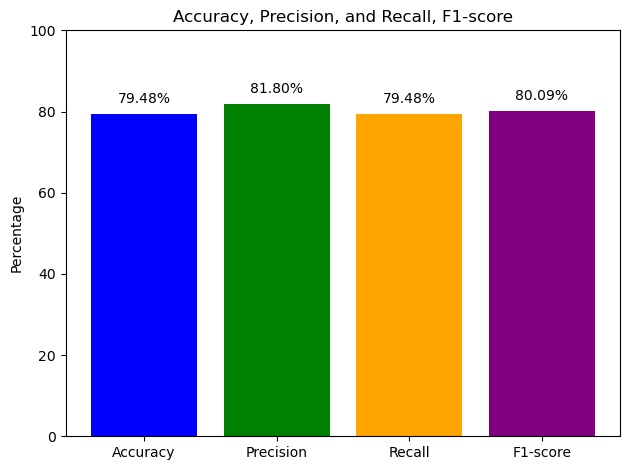

In [60]:
accuracy_percentage = accuracy * 100
precision_percentage = precision * 100
recall_percentage = recall * 100
f1_percentage = f1_score *100

# Plot bar chart
metrics = ['Accuracy', 'Precision', 'Recall', "F1-score"]
values = [accuracy_percentage, precision_percentage, recall_percentage, f1_percentage]

plt.bar(metrics, values, color=['blue', 'green', 'orange','purple'])
plt.ylabel('Percentage')
plt.title('Accuracy, Precision, and Recall, F1-score')
plt.ylim(0, 100)  # Set y-axis range to 0-100

# Annotate bars with percentage values
for i, v in enumerate(values):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [75]:
#lets have a look on classification reports
print("model Classification report: %s: \n %s\n" % (model_lgbm, classification_report(y_pred, y_test)))

model report: LGBMClassifier(bagging_fraction=0.9217562385065733, bagging_freq=4,
               feature_fraction=0.46129791756620747,
               lambda_l1=0.00989226009672252, lambda_l2=0.004817785980730727,
               min_child_samples=11, num_leaves=74): 
                         precision    recall  f1-score   support

            ACCOUNTANT       0.93      0.93      0.93        29
              ADVOCATE       0.90      0.93      0.92        29
           AGRICULTURE       0.50      0.67      0.57         6
               APPAREL       0.55      0.73      0.63        15
                  ARTS       0.44      0.50      0.47        16
            AUTOMOBILE       0.00      0.00      0.00         4
              AVIATION       0.90      0.83      0.86        23
               BANKING       0.65      0.83      0.73        18
                   BPO       0.00      0.00      0.00         1
  BUSINESS-DEVELOPMENT       0.93      0.93      0.93        27
                  CHEF     

In [79]:
#save model for the script
import pickle
filename = 'LGBMM.pkl'
pickle.dump(model_lgbm, open(filename, 'wb'))